# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

550x550 size

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from fastai.callbacks.tracker import SaveModelCallback
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode
import os
import psutil
import time

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(2)

In [5]:
pid = os.getpid()
py = psutil.Process(pid)

In [6]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: 5ca07634, DATE: 20191223


In [7]:
#UID='37c69040'
#DATE='20191217'
NB='03_01'

In [8]:
#uses images in images_256 folder
INFERENCE_MODEL='02_10_2-94b27c81_rn34_256-s2-r0-20191222'
#INFERENCE_MODEL='02_10_1-be4a9fe2_rn34_256-s2-r0-20191222'

In [9]:
SUBSET_DATA=False
SUBSET_LEN=171

VAL_FILE='val_20pct_0.csv'

TGT_HEIGHT = 256
IMAGE_WIDTH = 1100

In [47]:
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped_512/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

test_img = train_images/'cropped_512/test'

preds_path = data_dir/'preds'
preds_path.mkdir(exist_ok=True)

subs_path = data_dir/'submissions'
subs_path.mkdir(exist_ok=True)

In [11]:
filename = data_dir/'CAX_LogFacies_Train_File.csv'

In [12]:
file_test = data_dir/'CAX_LogFacies_Test_File.csv'

In [13]:
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

#### all data

In [14]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()


,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [15]:
test_df = pd.read_csv(file_test)
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [16]:
### Read preds

In [17]:
df_crops=pd.read_csv(preds_path/f'{INFERENCE_MODEL}.csv')

In [18]:
df_crops.head()

,Unnamed: 0,row_id,facies,well_id,crop_idx
0,0,0,2,well_5540,2
1,1,1,2,well_5540,2
2,2,2,2,well_5540,2
3,3,3,2,well_5540,2
4,4,4,2,well_5540,2


In [19]:
df_crops.row_id.max()

255

In [20]:
df_crops.drop(columns=['Unnamed: 0'],inplace=True)

In [21]:
'''
From 01_04_image_mask_2200_cropping.ipynb
def crop_n(img, crop_start):
    #(left, top, right, bottom)
    img_width, img_height = img.size
    if crop_start<4:
        cs = crop_start*(img_height)
    elif crop_start==7:
        cs = img_width-img_height
    else:
        cs = int(((crop_start-4)+0.5)*(img_height))
    #print(f'w {img_width}, h {img_height}, crop_start: {crop_start}, cs: {cs}')
    crop=((cs),0,(cs + img_height), img_height)
    #print(crop)
    return img.crop(crop)
'''

"\nFrom 01_04_image_mask_2200_cropping.ipynb\ndef crop_n(img, crop_start):\n    #(left, top, right, bottom)\n    img_width, img_height = img.size\n    if crop_start<4:\n        cs = crop_start*(img_height)\n    elif crop_start==7:\n        cs = img_width-img_height\n    else:\n        cs = int(((crop_start-4)+0.5)*(img_height))\n    #print(f'w {img_width}, h {img_height}, crop_start: {crop_start}, cs: {cs}')\n    crop=((cs),0,(cs + img_height), img_height)\n    #print(crop)\n    return img.crop(crop)\n"

In [22]:
'''            
            if c_ix==0:
                start=0
                end = TGT_HEIGHT-int(TGT_HEIGHT*0.2)
                start_odd = int(TGT_HEIGHT*0.5)-int(TGT_HEIGHT*0.2)
                end_odd = int(TGT_HEIGHT*0.5)+int(TGT_HEIGHT*0.2)
            elif c_ix==3:
                
            print(f'start: {start}, end: {end}')
'''

"            \n            if c_ix==0:\n                start=0\n                end = TGT_HEIGHT-int(TGT_HEIGHT*0.2)\n                start_odd = int(TGT_HEIGHT*0.5)-int(TGT_HEIGHT*0.2)\n                end_odd = int(TGT_HEIGHT*0.5)+int(TGT_HEIGHT*0.2)\n            elif c_ix==3:\n                \n            print(f'start: {start}, end: {end}')\n"

In [23]:
df_crops.facies.unique()

array([                   2,                    5,                    1,                    3,                    4,
       -9223372036854775808])

In [24]:
df_bad_preds=df_crops.loc[df_crops.facies == -9223372036854775808]

In [25]:
df_bad_preds.head()

,row_id,facies,well_id,crop_idx
2526,222,-9223372036854775808,well_6922,0
4574,222,-9223372036854775808,well_5607,0
6110,222,-9223372036854775808,well_5569,0
8926,222,-9223372036854775808,well_5145,0
9694,222,-9223372036854775808,well_6905,0


In [26]:
def missing_elements(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

In [27]:
def combine_wells(df, wells):
    well_frames=[]
    start_time = time.time()
    for j, well in enumerate(wells):
        memoryUse = py.memory_info()[0] / 2. ** 30
        if j==0:
           print(f'starting memory use: {memoryUse}') 
        elif memoryUse>86.0:
            print(f'killing process at image {j}, memory use: {memoryUse}')
            break
        if (j %100)==0:
            mid_time = time.time()
            print(f'well: {well} time: {mid_time-start_time}')
            
        df_w = df.loc[df['well_id'] == well]
        first_frames=[]
        for c_idx in range(4):
            df_r = df_w.loc[df_w['crop_idx'] == c_idx]
            df_r.row_id=df_r.row_id+(TGT_HEIGHT*c_idx)
            #print(f'c_idx: {c_idx}, row min: {df_r.row_id.min()}, max: {df_r.row_id.max()}')
            first_frames.append(df_r)
        df_first=pd.concat(first_frames)
        assert len(df_first)==TGT_HEIGHT*4
        #print(f'df_first, row min: {df_first.row_id.min()}, max: {df_first.row_id.max()}')
        first_facies=df_first.facies.unique().tolist()
        
        second_frames=[]
        for c_idx in range(4,7):
            df_r = df_w.loc[df_w['crop_idx'] == c_idx]
            df_r.row_id=df_r.row_id+(TGT_HEIGHT*(c_idx-4))+int(TGT_HEIGHT*0.5)
            second_frames.append(df_r)
            #print(f'c_idx: {c_idx}, row min: {df_r.row_id.min()}, max: {df_r.row_id.max()}')
        df_second=pd.concat(second_frames)
        assert len(df_second)==TGT_HEIGHT*3
        #print(f'df_second, row min: {df_second.row_id.min()}, max: {df_second.row_id.max()}')
        second_facies=df_second.facies.unique().tolist()
        
        df_last = df_w.loc[df_w['crop_idx'] == 7]
        df_last.row_id=df_last.row_id+IMAGE_WIDTH-TGT_HEIGHT
        assert len(df_last)==TGT_HEIGHT
        #print(f'c_idx: 7, row min: {df_last.row_id.min()}, max: {df_last.row_id.max()}')
        
        #drop last 10% 
        #print(f'df_first pre drop: {len(df_first)},  row min: {df_first.row_id.min()}, max: {df_first.row_id.max()}')
        #print(f'int(IMAGE_WIDTH*0.90): {int(IMAGE_WIDTH*0.90)}, max rows: {df_first.row_id.max()}')
        idxs=df_first[df_first['row_id']>int(IMAGE_WIDTH*0.90)].index
        df_first.drop(idxs, inplace=True)
        #print(f'df_first after drop: {len(df_first)}, idxs: {len(idxs)},  row min: {df_first.row_id.min()}, max: {df_first.row_id.max()}')
        
        #print(f'df_last pre drop: {len(df_last)},  row min: {df_last.row_id.min()}, max: {df_last.row_id.max()}')
        idxs=df_last[df_last['row_id']<=int(IMAGE_WIDTH*0.90)].index
        df_last.drop(idxs, inplace=True)
        #print(f'df_last after drop: {len(df_last)}, idxs: {len(idxs)},  row min: {df_last.row_id.min()}, max: {df_last.row_id.max()}')
        
        frames=[df_first, df_last]
        df_s=pd.concat(frames)
        df_s = df_s.reset_index(drop=True)
        dup=df_s[df_s.duplicated(['row_id'])]
        #print(f'df_s dup: {dup}')
        #print(f'df_s: {len(df_s)}, {df_s.row_id.min()}, max: {df_s.row_id.max()}')
        
        start=int(TGT_HEIGHT*0.8)
        end=int(TGT_HEIGHT*0.2)+TGT_HEIGHT

        #replace ends
        df_s.reset_index(inplace=True)
        for c_idx in range(3):
            rs=start+(TGT_HEIGHT*c_idx)
            ed=end+(TGT_HEIGHT*c_idx)
            #print(f'c_idx: {c_idx}, rs: {rs}, ed: {ed}')
            for i in df_s.index:
                if (df_s.iloc[i].row_id>start) and (df_s.iloc[i].row_id<ed):
                    for b in df_second.index:
                        if i == b:
                            df_s.at[i, 'facies'] = df_second.at[b, 'facies'] 
                            df_s.at[i, 'crop_idx'] = df_second.at[b, 'crop_idx'] 
        u=df_s.facies.unique().tolist()
        bad_count=0
        f_bad=list(set(u) - set(range(7)))
        if len(f_bad)>0:
            for f in f_bad:
                idxs=df_s[df_s['facies']==f].index
                for i in idxs:
                    df_s.at[i, 'facies'] = '2'
                    bad_count+=1
        #print(f'{bad_count} bad facies pred in well: {well}')
        
        if len(df_s)!=1100:
            print(f'rows: {len(df_s)} {df.index}')
            m=missing_elements(df_s.index)
            print(m)
            assert True==False
        well_frames.append(df_s)
    df_t = pd.concat(well_frames)
    end_time = time.time()
    print(f'elapsed: {end_time-start_time}')
    return df_t

In [28]:
wells=df_crops.well_id.unique()
#wells=wells[:10]
df = combine_wells(df_crops, wells)

starting memory use: 1.2862930297851562
well: well_5540 time: 0.0001862049102783203


/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


well: well_6802 time: 132.5225579738617
well: well_6000 time: 263.1425287723541
well: well_5841 time: 393.7736248970032
well: well_6416 time: 527.3672618865967
well: well_5489 time: 661.8840916156769
well: well_6197 time: 825.2553133964539
well: well_6816 time: 1018.9061479568481
well: well_6490 time: 1217.506361246109
well: well_5236 time: 1412.9937238693237
well: well_5994 time: 1606.4418354034424
well: well_5660 time: 1800.353830575943
well: well_6574 time: 1996.3105218410492
well: well_6311 time: 2187.0226180553436
well: well_6633 time: 2382.973159790039
well: well_6837 time: 2576.1974472999573
well: well_5832 time: 2768.796442270279
well: well_6586 time: 2960.608704805374
well: well_6446 time: 3150.8176357746124
well: well_5629 time: 3341.4504511356354
elapsed: 3559.128677368164


In [29]:
df.to_csv(preds_path/f'{INFERENCE_MODEL}_patched.csv')

In [30]:
df.head(n=500)

,index,row_id,facies,well_id,crop_idx
0,0,0,2,well_5540,0
1,1,1,2,well_5540,0
2,2,2,2,well_5540,0
3,3,3,2,well_5540,0
4,4,4,2,well_5540,0
...,...,...,...,...,...
495,495,495,2,well_5540,1
496,496,496,2,well_5540,1
497,497,497,2,well_5540,1
498,498,498,2,well_5540,1


In [31]:
df.facies.unique()

array([2, 1, 3, 5, 4])

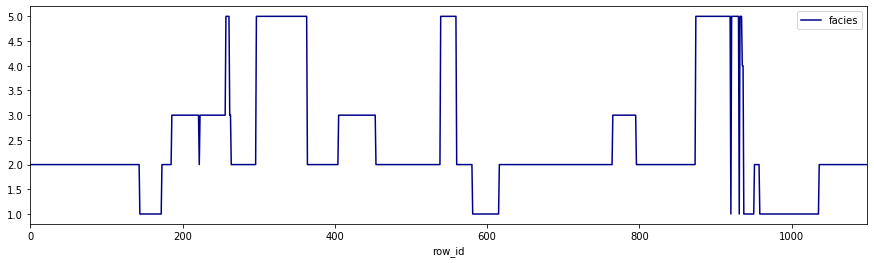

In [32]:
w=df.loc[df['well_id'] == 'well_5540']
ax1 = w.plot.line(x='row_id',
                       y='facies',
                       c='DarkBlue', figsize=(15,4))
#ax1.set_ylim(0,7)

well_5540_GR.png


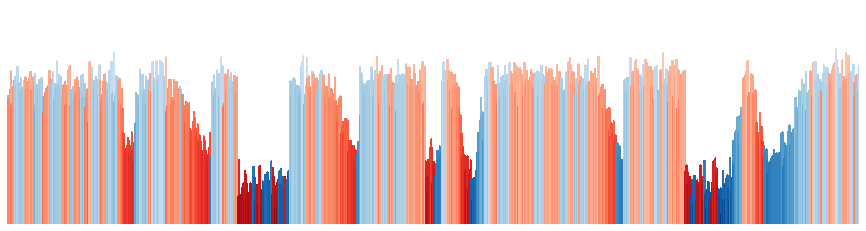

In [33]:
img_f = 'well_5540_GR.png'
p='train_images/mask_fill/test/'
print(img_f)
img_gr = open_image(data_dir/p/img_f)
img_gr.show(figsize=(18,4))

In [34]:
len(df.well_id.unique())

2000

In [35]:
len(df)

2200000

In [36]:
2000*1100

2200000

### Sort and format for submission

In [37]:
df = df.sort_values(['well_id','row_id'])

In [39]:
df.reset_index(drop=True, inplace=True)

In [40]:
df.head()

,index,row_id,facies,well_id,crop_idx
0,0,0,2,well_5000,0
1,1,1,2,well_5000,0
2,2,2,2,well_5000,0
3,3,3,2,well_5000,0
4,4,4,2,well_5000,0


In [41]:
df.drop(columns=['index', 'crop_idx','well_id','row_id'],inplace=True)

In [42]:
df.reset_index(drop=False, inplace=True)

In [43]:
df.head()

,index,facies
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


In [44]:
df.rename(columns={'index': 'unique_id', 'facies': 'label'}, inplace=True)

In [45]:
df.unique_id = 'CAX_'+ df.unique_id.astype(str)

In [46]:
df.head()

,unique_id,label
0,CAX_0,2
1,CAX_1,2
2,CAX_2,2
3,CAX_3,2
4,CAX_4,2


In [48]:
df.to_csv(f'{INFERENCE_MODEL}.csv', index=False)